In [9]:
!nvidia-smi

Fri Jul 12 16:53:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                  N/A |
| N/A   57C    P0              28W /  70W |   1613MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [10]:
!pip install -q transformers flash_attn timm einops peft

In [11]:
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Generated text: colorful
The predominant color of the truck is colorful.


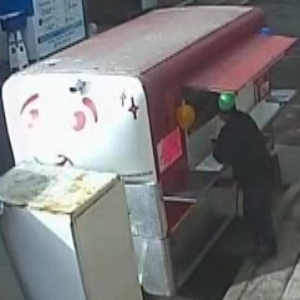

Generated text: white
The predominant color of the car is white.


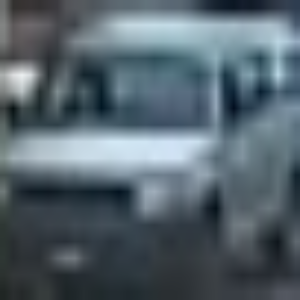

Generated text: white
The predominant color of the car is white.


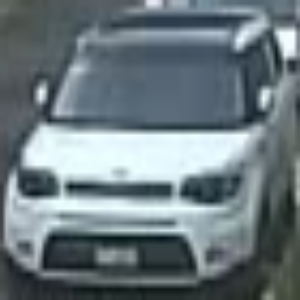

Generated text: white
The predominant color of the car is white.


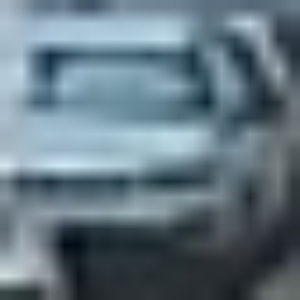

In [37]:
import cv2
import torch
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import json
import os
from google.colab.patches import cv2_imshow

# Cargar Florence-2
CHECKPOINT = "microsoft/Florence-2-base-ft"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True).to(DEVICE)
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True)

# Cargar el JSON con las detecciones
json_path = '/content/drive/MyDrive/07-11-2024-23-19-18_files_list/tmpaycg7f9i_chunk_1_of_4350.mp4_results.json'  # Actualiza esta ruta con la ruta a tu archivo JSON
with open(json_path, 'r') as file:
    data = json.load(file)

def get_object_from_frame(frame_number, track_id, data):
    # Buscar el frame y track_id en el JSON
    for frame in data['data']:
        if frame and frame[0]['frame_number'] == frame_number:
            for obj in frame:
                if obj['track_id'] == track_id:
                    return obj
    return None

def detect_color(image, object_name):
    # Convertir imagen a PIL
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Preparar entrada para Florence-2
    task_prompt = f"<COLOR_DETECTION> The {object_name} is"
    inputs = processor(text=task_prompt, images=pil_image, return_tensors="pt").to(DEVICE)

    # Generar detección de color
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=50,
            num_beams=3,
            early_stopping=True
        )

    # Decodificar y procesar la respuesta
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Imprimir el texto generado para depuración
    print("Generated text:", generated_text)

    # Buscar la etiqueta de color en la respuesta
    if 'The color of the' in generated_text:
        color = generated_text.split('The color of the')[-1].split('is')[1].strip().split('.')[0]
    else:
        color = generated_text.strip()

    return color

def main(frame_number, track_id, data, image_dir):
    # Obtener el objeto del frame
    obj = get_object_from_frame(frame_number, track_id, data)
    if obj is None:
        print(f"No object found with track_id {track_id} in frame {frame_number}.")
        return

    # Cargar la imagen del frame
    image_path = os.path.join(image_dir, f"tmpaycg7f9i_chunk_1_of_4350_annotated_{frame_number}.jpg")
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image not found at {image_path}.")
        return

    # Recortar el objeto de la imagen
    box = obj['box']
    x1, y1, x2, y2 = map(int, [box['x1'], box['y1'], box['x2'], box['y2']])
    cropped_image = image[y1:y2, x1:x2]

    # Aumentar el tamaño de la imagen recortada para una mejor visualización
    resized_cropped_image = cv2.resize(cropped_image, (300, 300))

    # Detectar el color del objeto
    color = detect_color(resized_cropped_image, obj['name'])

    print(f"The predominant color of the {obj['name']} is {color}.")

    # Mostrar el objeto recortado con el color detectado
    cv2_imshow(resized_cropped_image)

# Ejemplos de uso
example_frames = [
    (1561, 7),  # Ejemplo 1
    (261, 5),   # Ejemplo 2
    (0, 1),     # Ejemplo 3
    (4194, 6)   # Ejemplo 4
]

image_dir = '/content/drive/MyDrive/tmpaycg7f9i_chunk_1_of_4350_annotated_images'  # Directorio donde se encuentran las imágenes de los frames

for frame_number, track_id in example_frames:
    main(frame_number, track_id, data, image_dir)


In [38]:
pip install fpdf pillow


  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40702 sha256=160eb83a3883fc756df91636c36b6d30d9f11e6355a7e4d94b2baa8b90636125
  Stored in directory: /root/.cache/pip/wheels/f9/95/ba/f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built fpdf


In [39]:
import cv2
import torch
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import json
import os
from google.colab.patches import cv2_imshow
from fpdf import FPDF

# Cargar Florence-2
CHECKPOINT = "microsoft/Florence-2-base-ft"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True).to(DEVICE)
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True)

# Cargar el JSON con las detecciones
json_path = '/content/drive/MyDrive/07-11-2024-23-19-18_files_list/tmpaycg7f9i_chunk_1_of_4350.mp4_results.json'  # Actualiza esta ruta con la ruta a tu archivo JSON
with open(json_path, 'r') as file:
    data = json.load(file)

def get_object_from_frame(frame_number, track_id, data):
    # Buscar el frame y track_id en el JSON
    for frame in data['data']:
        if frame and frame[0]['frame_number'] == frame_number:
            for obj in frame:
                if obj['track_id'] == track_id:
                    return obj
    return None

def detect_color(image, object_name):
    # Convertir imagen a PIL
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Preparar entrada para Florence-2
    task_prompt = f"<COLOR_DETECTION> The {object_name} is"
    inputs = processor(text=task_prompt, images=pil_image, return_tensors="pt").to(DEVICE)

    # Generar detección de color
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=50,
            num_beams=3,
            early_stopping=True
        )

    # Decodificar y procesar la respuesta
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Imprimir el texto generado para depuración
    print("Generated text:", generated_text)

    # Buscar la etiqueta de color en la respuesta
    if 'The color of the' in generated_text:
        color = generated_text.split('The color of the')[-1].split('is')[1].strip().split('.')[0]
    else:
        color = generated_text.strip()

    return color

def main(frame_number, track_id, data, image_dir):
    # Obtener el objeto del frame
    obj = get_object_from_frame(frame_number, track_id, data)
    if obj is None:
        print(f"No object found with track_id {track_id} in frame {frame_number}.")
        return None, None

    # Cargar la imagen del frame
    image_path = os.path.join(image_dir, f"tmpaycg7f9i_chunk_1_of_4350_annotated_{frame_number}.jpg")
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image not found at {image_path}.")
        return None, None

    # Recortar el objeto de la imagen
    box = obj['box']
    x1, y1, x2, y2 = map(int, [box['x1'], box['y1'], box['x2'], box['y2']])
    cropped_image = image[y1:y2, x1:x2]

    # Aumentar el tamaño de la imagen recortada para una mejor visualización
    resized_cropped_image = cv2.resize(cropped_image, (300, 300))

    # Detectar el color del objeto
    color = detect_color(resized_cropped_image, obj['name'])

    print(f"The predominant color of the {obj['name']} is {color}.")

    return resized_cropped_image, f"The predominant color of the {obj['name']} is {color}."

# Crear el PDF
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)

# Ejemplos de uso
example_frames = [
    (1561, 7),  # Ejemplo 1
    (261, 5),   # Ejemplo 2
    (0, 1),     # Ejemplo 3
    (4194, 6)   # Ejemplo 4
]

image_dir = '/content/drive/MyDrive/tmpaycg7f9i_chunk_1_of_4350_annotated_images'  # Directorio donde se encuentran las imágenes de los frames

for frame_number, track_id in example_frames:
    image, result_text = main(frame_number, track_id, data, image_dir)
    if image is not None:
        # Guardar la imagen recortada en un archivo temporal
        temp_image_path = f"/content/temp_cropped_{frame_number}_{track_id}.jpg"
        cv2.imwrite(temp_image_path, image)

        # Añadir una nueva página al PDF
        pdf.add_page()

        # Añadir la imagen al PDF
        pdf.image(temp_image_path, x=10, y=30, w=100)

        # Añadir el texto del resultado al PDF
        pdf.set_xy(10, 10)
        pdf.set_font("Arial", size=12)
        pdf.multi_cell(0, 10, result_text)

# Guardar el PDF
pdf_output_path = '/content/detecciones_florence2.pdf'
pdf.output(pdf_output_path)
print(f"PDF saved to {pdf_output_path}")

# Mostrar el PDF en Google Colab
from google.colab import files
files.download(pdf_output_path)


Generated text: colorful
The predominant color of the truck is colorful.
Generated text: white
The predominant color of the car is white.
Generated text: white
The predominant color of the car is white.
Generated text: white
The predominant color of the car is white.
PDF saved to /content/detecciones_florence2.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>